In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
from vnstock import stock_historical_data


In [2]:
# Parameters 
RSI_PERIOD = 14
RSI_OVERSOLD = 30
RSI_OVERBOUGHT = 70
initial_investment = 160_000_000

In [3]:
# List of companies (replace with actual list of 30 companies)
companies =  ['SSI', 'BCM','VHM','VIC','VRE','BVH','POW','GAS','ACB','BID',
'CTG','HDB','MBB','SSB','SHB','STB','TCB','TPB','VCB','VIB','VPB','HPG',
'GVR','MSN','VNM','SAB','VJC','MWG','PLX','FPT']

In [4]:
def calculate_indicators(df):
    if df.empty:
        return df
    df['RSI'] = ta.momentum.RSIIndicator(df['close'], RSI_PERIOD).rsi()
    df['Bollinger_high'] = ta.volatility.bollinger_hband(df['close'], window=15, window_dev=2)
    df['Bollinger_low'] = ta.volatility.bollinger_lband(df['close'], window=15, window_dev=2)
    df['Previous_RSI'] = df['RSI'].shift(1)
    df['Previous_RSI'].fillna(0, inplace=True)
    return df

In [5]:
def boll_rsi_strategy(data):
    sell_price = []
    buy_price = []
    position = 0
    for i in range(len(data)):
        if data['close'][i] <= data['Bollinger_low'][i] and data['RSI'][i] < RSI_OVERSOLD and position == 0:
            position = 1
            buy_price.append(data['close'][i])
            sell_price.append(np.nan)
        elif data['close'][i] >= data['Bollinger_high'][i] and data['RSI'][i] > RSI_OVERBOUGHT and position == 1:
            position = 0
            sell_price.append(data['close'][i])
            buy_price.append(np.nan)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return buy_price, sell_price

In [6]:


def analyze_company(ticker):
    data = stock_historical_data(ticker, '2021-01-01', '2024-01-01')
    data = data.set_index(pd.DatetimeIndex(data['time'].values))
    data = calculate_indicators(data)
    
    buy_price, sell_price = boll_rsi_strategy(data)
    data['Buy'] = buy_price
    data['Sell'] = sell_price
    
    cash = initial_investment
    holdings = 0
    portfolio_values = []

    for i in range(len(data)):
        if not np.isnan(buy_price[i]):
            shares_to_buy = cash // buy_price[i]
            cash -= shares_to_buy * buy_price[i]
            holdings += shares_to_buy
        elif not np.isnan(sell_price[i]):
            cash += holdings * sell_price[i]
            holdings = 0
        current_value = cash + holdings * data['close'][i]
        portfolio_values.append(current_value)

    data['Portfolio_Value'] = portfolio_values
    data['Rate_of_Return'] = data['Portfolio_Value'].pct_change().fillna(0)
    data['Accumulated_Profit'] = data['Portfolio_Value'] - initial_investment

    return data

In [7]:

results = []

for company in companies:
    try:
        result = analyze_company(company)
        results.append({
            'Company': company,
            'Final Portfolio Value': result['Portfolio_Value'].iloc[-1],
            'Total Profit': result['Accumulated_Profit'].iloc[-1],
            'Rate of Return': (result['Portfolio_Value'].iloc[-1] - initial_investment)/initial_investment * 100,
        })
    except Exception as e:
        print(f"Error occurred for {company}: {e}")

results_df = pd.DataFrame(results)
results_df.to_csv('result/RSI_BOLL_Strategy_Results.csv', index=False)



C:\Users\Admin\AppData\Local\Temp\ipykernel_26820\1219599999.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Previous_RSI'].fillna(0, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_26820\239439446.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['close'][i] <= data['Bollinger_low'][i] and data['RSI'][i] < RSI_OVE

In [8]:
average_rate_of_return = results_df['Rate of Return'].mean()
print("Average Rate of Return for 30 companies:", average_rate_of_return)

Average Rate of Return for 30 companies: 14.859534229166664


C:\Users\Admin\AppData\Local\Temp\ipykernel_26820\1219599999.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Previous_RSI'].fillna(0, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_26820\239439446.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['close'][i] <= data['Bollinger_low'][i] and data['RSI'][i] < RSI_OVE

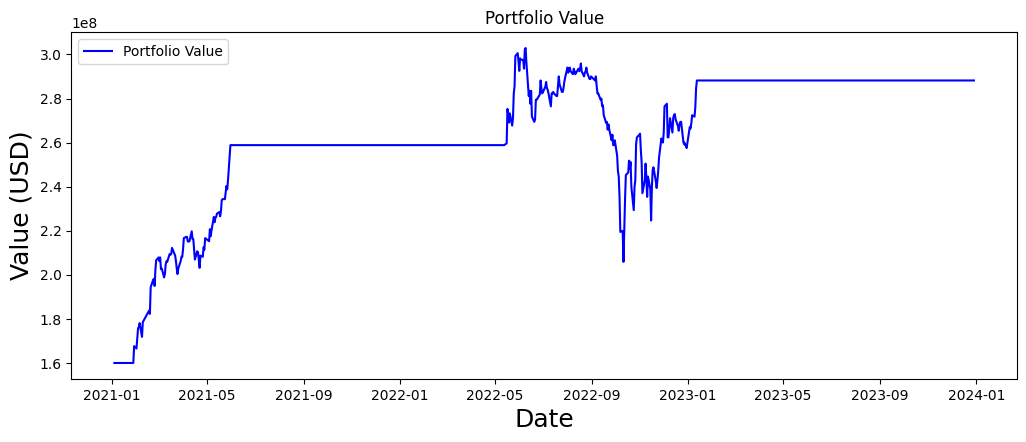

In [9]:
# Plotting (Example for one company)
company_data = analyze_company('ACB')
plt.figure(figsize=(12.2, 4.5))
plt.plot(company_data.index, company_data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Portfolio Value')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Value (USD)', fontsize=18)
plt.legend(loc='upper left')
plt.show()
